In [1]:
path_train = 'training_set_task3/'
path_test = 'test_set_task3/'

In [42]:
import json
import cv2
import string
import numpy as np
import itertools
import matplotlib.pyplot as plt

In [97]:
# Load training data from txt file
with open('training_set_task3/training_set_task3.txt') as f:
    train_data = json.load(f)

# Initialize empty lists to store image, text, and label data
images,texts,labels = [],[],[]

from PIL import Image   
# Iterate through training data and process image, text, and label data
for data in train_data:
    #print(data['image'], data['labels'])
    img = Image.open(path_train + data['image'])
    img = img.resize((224, 224))
    images.append(np.array(img))
    text = data['text'].replace('\n', ' ')
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join(text.split()).lower()
    texts.append(text)
    labels.append(data['labels'])


In [99]:
def one_hot_encode_labels(labels):
    all_labels = list(set(list(itertools.chain(*labels)))) + ['']
    one_hot_labels = np.zeros((len(labels), len(all_labels)))
    for i, label_list in enumerate(labels):
        if label_list:
            for label in label_list:
                one_hot_labels[i, all_labels.index(label)] = 1
        else:
            one_hot_labels[i, -1] = 1
    return one_hot_labels

In [100]:
one_hot_labels = one_hot_encode_labels(labels)
one_hot_labels = np.array(one_hot_labels)
print(one_hot_labels.shape)
print(one_hot_labels)

(687, 23)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [35]:
# Save data to json file
t_data = {
    'images': images.tolist(),
    'texts': texts,
    'labels_onehot': one_hot_labels.tolist(),
    'labels_string': labels,
    'all_labels': all_labels
}

with open('training_set_task3/training_task3.json', 'w') as f:
    json.dump(t_data, f)

# Load data from json file
with open('training_set_task3/training_task3.json', 'r') as f:
    t_data = json.load(f)

train_images = np.array(t_data['images'])
train_texts = t_data['texts']
train_one_hot_labels = np.array(t_data['labels_onehot'])
train_labels = t_data['labels_string'] 
train_all_labels = t_data['all_labels'] 


(687, 224, 224, 3)
['Appeal to fear/prejudice', 'Loaded Language', 'Name calling/Labeling', 'Slogans', 'Smears', 'Transfer']


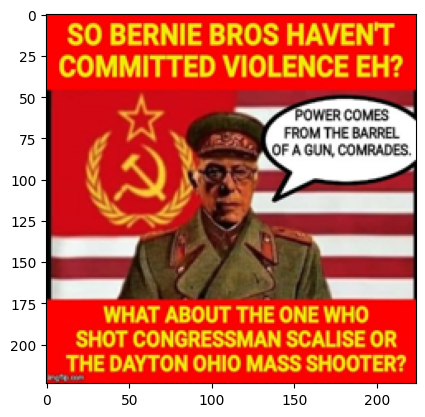

In [37]:
print(train_images.shape)
imgplot = plt.imshow(train_images[2])
print(train_labels[2])

In [40]:
# Load testing data from txt file
with open('test_set_task3/test_set_task3.txt') as f:
    test_data = json.load(f)

# Initialize empty lists to store image, text, and label data
test_images,test_texts,test_labels = [],[],[]
for data in test_data:
    #print(data['image'], data['labels'])

    img = Image.open(path_test + data['image'])
    img = img.resize((224, 224))
    test_images.append(np.array(img))
    text = data['text'].replace('\n', ' ')
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join(text.split()).lower()
    test_texts.append(text)
    test_labels.append(data['labels'])
    


In [105]:
# Convert image data to numpy array
test_images = np.array(test_images)

# Create one-hot encoded labels
test_all_labels = list(set(list(itertools.chain(*test_labels))))
test_all_labels.append('')
test_one_hot_labels = []


test_one_hot_labels = one_hot_encode_labels(test_labels)
test_one_hot_labels = np.array(test_one_hot_labels)
print(test_one_hot_labels.shape)
print(test_one_hot_labels)

(200, 23)
[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [16]:

# Save data to json file
test_data = {
    'images': test_images.tolist(),
    'texts': test_texts,
    'labels_onehot': test_one_hot_labels.tolist(),
    'labels_string': test_labels,
    'all_labels': test_all_labels
}


with open('test_set_task3/testing_task3.json', 'w') as f:
    json.dump(test_data, f)

# Load data from json file
with open('test_set_task3/testing_task3.json', 'r') as f:
    test_data = json.load(f)

test_images = np.array(test_data['images'])
test_texts = test_data['texts']
test_one_hot_labels = np.array(test_data['labels_onehot'])
test_labels = test_data['labels_string']
test_all_labels = test_data['all_labels']

(200, 224, 224, 3)
['Doubt']


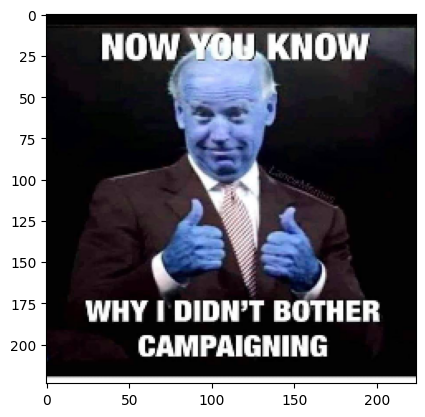

In [17]:
print(test_images.shape)
imgplot = plt.imshow(test_images[11])
print(test_labels[11])

In [18]:
num_classes = len(all_labels)
input_shape = images.shape[1:]

In [49]:
from keras.models import Model
from keras.layers import *
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras import layers

learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
image_size = 100
patch_size = 6
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 2
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  
transformer_layers = 6
mlp_head_units = [2048, 1024] 
x_train=images
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)

data_augmentation.layers[0].adapt(x_train)
count=0

# code taken from keras documentation for vision transformers
def mlp(x, hidden_units, dropout_rate):
    global count
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu, name='feats'+str(count))(x)
        x = layers.Dropout(dropout_rate)(x)
        count+=1
    return x

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


Image size: 100 X 100
Patch size: 6 X 6
Patches per image: 256
Elements per patch: 108


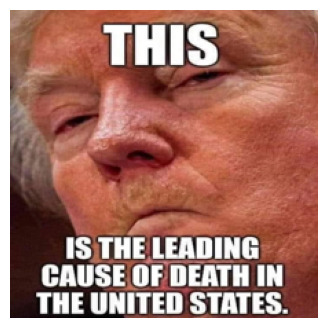

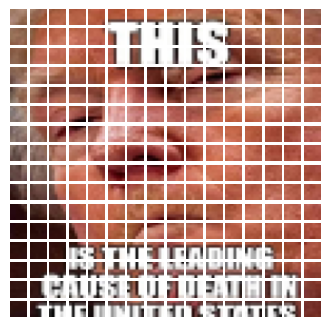

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [50]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    augmented = data_augmentation(inputs) # data augmentation wasn't used
    patches = Patches(patch_size)(augmented)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    j=0
    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.2
        )(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.2)
        encoded_patches = layers.Add()([x3, x2])
        j+=1

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.2)(representation)
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.4)
    logits = layers.Dense(num_classes,activation='sigmoid')(features)
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [51]:
!pip3 install tensorflow-addons
import tensorflow_addons as tfa

x_train=images[:500]
y_train=one_hot_labels[:500]
x_test=test_images
y_test=test_one_hot_labels
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)


(500, 224, 224, 3) (500, 23) (200, 224, 224, 3) (200, 23)


In [52]:

def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)
    model.summary()
    model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=["categorical_accuracy"])
    history = model.fit(x=x_train,y=y_train,batch_size=batch_size,epochs=30,validation_data=[x_test,y_test])
    return history
vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 data_augmentation (Sequential)  (None, 100, 100, 3)  7          ['input_3[0][0]']                
                                                                                                  
 patches_4 (Patches)            (None, None, 108)    0           ['data_augmentation[0][0]']      
                                                                                                  
 patch_encoder_2 (PatchEncoder)  (None, 256, 64)     23360       ['patches_4[0][0]']        

 dropout_32 (Dropout)           (None, 256, 128)     0           ['feats2[0][0]']                 
                                                                                                  
 feats3 (Dense)                 (None, 256, 64)      8256        ['dropout_32[0][0]']             
                                                                                                  
 dropout_33 (Dropout)           (None, 256, 64)      0           ['feats3[0][0]']                 
                                                                                                  
 add_27 (Add)                   (None, 256, 64)      0           ['dropout_33[0][0]',             
                                                                  'add_26[0][0]']                 
                                                                                                  
 layer_normalization_30 (LayerN  (None, 256, 64)     128         ['add_27[0][0]']                 
 ormalizat

                                                                                                  
 add_34 (Add)                   (None, 256, 64)      0           ['multi_head_attention_17[0][0]',
                                                                  'add_33[0][0]']                 
                                                                                                  
 layer_normalization_37 (LayerN  (None, 256, 64)     128         ['add_34[0][0]']                 
 ormalization)                                                                                    
                                                                                                  
 feats10 (Dense)                (None, 256, 128)     8320        ['layer_normalization_37[0][0]'] 
                                                                                                  
 dropout_40 (Dropout)           (None, 256, 128)     0           ['feats10[0][0]']                
          

2/2 [==============================] - 7s 4s/step - loss: 0.2984 - categorical_accuracy: 0.3800 - val_loss: 0.3049 - val_categorical_accuracy: 0.3650
Epoch 8/15
2/2 [==============================] - 7s 4s/step - loss: 0.2962 - categorical_accuracy: 0.3600 - val_loss: 0.3027 - val_categorical_accuracy: 0.3700
Epoch 9/15
2/2 [==============================] - 7s 4s/step - loss: 0.2842 - categorical_accuracy: 0.3840 - val_loss: 0.3030 - val_categorical_accuracy: 0.3350
Epoch 10/15
2/2 [==============================] - 8s 4s/step - loss: 0.2838 - categorical_accuracy: 0.3720 - val_loss: 0.3056 - val_categorical_accuracy: 0.2900
Epoch 11/15
2/2 [==============================] - 9s 4s/step - loss: 0.2801 - categorical_accuracy: 0.3640 - val_loss: 0.3079 - val_categorical_accuracy: 0.3500
Epoch 12/15
2/2 [==============================] - 9s 4s/step - loss: 0.2740 - categorical_accuracy: 0.3980 - val_loss: 0.3058 - val_categorical_accuracy: 0.3250
Epoch 13/15
2/2 [=========================

In [82]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_metrics(history, metric_name):
    plt.plot(history.history[metric_name])
    plt.plot(history.history['val_'+metric_name])
    plt.title(f'model {metric_name}')
    plt.ylabel(metric_name)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    

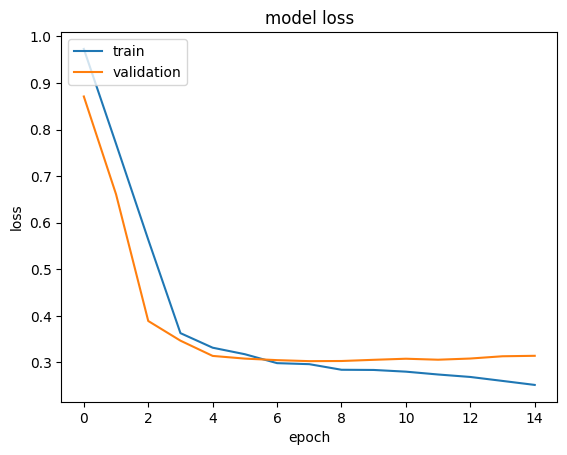

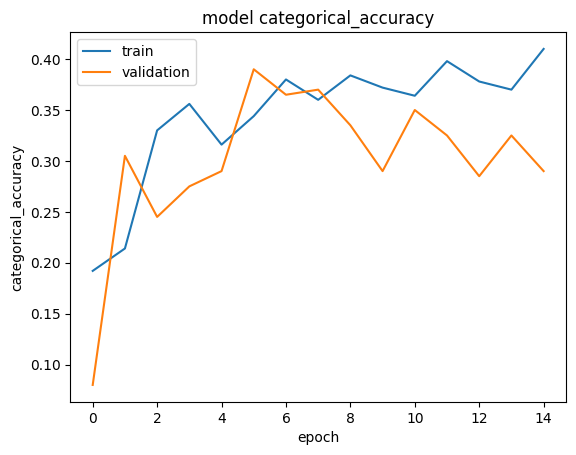

In [83]:
plot_metrics(history, 'loss')
plot_metrics(history, 'categorical_accuracy')

In [80]:
# take features from the model
feature_network = Model(vit_classifier.input, vit_classifier.get_layer('feats13').output)
X_train = feature_network.predict(images)
X_valid = feature_network.predict(test_images)
y_train=one_hot_labels
y_valid=test_one_hot_labels
print(X_train.shape, y_train.shape, X_valid.shape,y_valid.shape)

7/7 [==============================] - 1s 158ms/step
(687, 1024) (687, 23) (200, 1024) (200, 23)
[ 1.9890243   2.8456032  -0.03421192 ... -0.1693623  -0.00389141
 -0.08697781]


In [72]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report, f1_score

In [76]:

# create an instance of RandomForestClassifier with 5 trees
model = RandomForestClassifier(n_estimators=10, random_state=42)
model.fit(X_train, y_train)

# make predictions on the train and validation sets
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)

train_acc = accuracy_score(y_train, y_train_pred)
valid_acc = accuracy_score(y_valid, y_valid_pred)

print("Training accuracy: ", train_acc)
print("Validation accuracy: ", valid_acc)
print("F1 score: ", f1_score(y_valid, y_valid_pred, average='weighted'))

Training accuracy:  0.8427947598253275
Validation accuracy:  0.015
F1 score:  0.2299021383667865


In [77]:
clf = LogisticRegression(C = 4, penalty='l2', solver = 'liblinear', random_state=40)

model = OneVsRestClassifier(clf)
model.fit(X_train, y_train)

y_train_pred_proba = model.predict_proba(X_train)
y_valid_pred_proba = model.predict_proba(X_valid)

y_pred = (y_train_pred_proba > 0.3) 
y_train_new=(y_train > 0.3) 


y_pred1 = (y_valid_pred_proba > 0.3) 
y_valid_new=(y_valid > 0.3) 

print("Training accuracy: ", accuracy_score(y_train_new, y_pred))
print("Validation Accuracy: ", accuracy_score(y_valid_new, y_pred1))
print("F1 score: ", f1_score(y_valid_new,y_pred1,average='weighted'))

Training accuracy:  0.9985443959243085
Validation Accuracy:  0.015
F1 score:  0.3160402636915654
